# RQ6 Posting Effectiveness

For this question, we need to consider two datasets:
* instagram_profiles
* instagram_posts

## Finding the average time a user lets pass
To find the average time a user lets pass before posting another post, one can do the following:
1. Get all profiles from the profiles dataset.
2. For each profile, find the maximum and minimum post time in the posts dataset.
3. Find the average by subtracting the minimum post time from the maximum post time and dividing by the number of posts the profile has.
4. Take the average of all post frequency averages.

### Caveats:
* Not all profiles that appear in the profiles dataset also appear in the posts dataset (even if they have posts). Since we care about finding the average time, a user MUST exist in the posts dataset for the analysis to be conclusive.
* The number of posts for each profile shown in the profiles dataset is unreliable, meaning that it doesn't mean that all those posts will be found in the posts dataset.

### Choices:
* Only consider users that appear in both posts and profiles dataset.
* Remove posts that don't have a post time.

### Approach
The profiles dataset has over 4 million rows and posts dataset has over 40 million rows. Finding all of the rows that belong to each user using pandas queries is very expensive, as all 40 million rows need to be scanned for each profile in the profiles dataset.

Instead of relying on querying, the rows belonging to each user are retrieved using indexing instead which is an O(1) operation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [94]:
profiles = pd.read_csv('data/instagram_profiles.csv', sep='\t', usecols=['profile_id', 'profile_name', 'n_posts', 'following', 'followers'])
profiles = profiles[profiles.profile_id.notnull()]
profiles.profile_id = profiles.profile_id.astype('Int64')
profiles = profiles.drop_duplicates(subset='profile_id', keep="last")
profiles = profiles.sort_values(by='profile_id')

In [168]:
posts = pd.read_csv('data/instagram_posts.csv', sep='\t', usecols=['profile_id', 'cts', 'numbr_likes', 'number_comments'], parse_dates=['cts'], index_col=False)

In [185]:
profile_time = posts[['profile_id', 'cts']]
time_likes_comments = posts[['cts', 'numbr_likes', 'number_comments']]

In [170]:
filtered_posts = profile_time.dropna()
filtered_posts = filtered_posts[filtered_posts.profile_id.isin(profiles.profile_id)]
sorted_posts = filtered_posts.sort_values(by='profile_id')

In [171]:
profiles_with_posts = profiles[profiles.profile_id.isin(sorted_posts.profile_id.unique())]

In [172]:
# count the actual number of posts
profiles_with_posts['true_n_posts'] = sorted_posts.groupby('profile_id')['profile_id'].count().values

C:\Users\Jonas\AppData\Local\Temp\ipykernel_3728\4124026347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['true_n_posts'] = sorted_posts.groupby('profile_id')['profile_id'].count().values


In [173]:
sorted_post_times = sorted_posts.cts.values

In [174]:
# Find the indeces
profiles_with_posts['start_index'] = profiles_with_posts.true_n_posts.shift(1)
profiles_with_posts.start_index = profiles_with_posts.start_index.cumsum().astype('Int64')
profiles_with_posts.iloc[0, -1] = 0

C:\Users\Jonas\AppData\Local\Temp\ipykernel_3728\1224487006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['start_index'] = profiles_with_posts.true_n_posts.shift(1)
C:\Users\Jonas\AppData\Local\Temp\ipykernel_3728\1224487006.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts.start_index = profiles_with_posts.start_index.cumsum().astype('Int64')


In [175]:
def find_time_stamps(profile_id, n_posts, start_index):

    start_index = int(start_index)
    n_posts = int(n_posts)
    profile_post_times = sorted_post_times[start_index:start_index + n_posts]
    
    min_post_time = profile_post_times.min()
    max_post_time = profile_post_times.max()
  
    return max_post_time, min_post_time

In [176]:
max_post, min_post = np.vectorize(find_time_stamps)(profiles_with_posts.profile_id, profiles_with_posts.true_n_posts, profiles_with_posts.start_index)

In [177]:
profiles_with_posts['max_post'] = max_post
profiles_with_posts['min_post'] = min_post

C:\Users\Jonas\AppData\Local\Temp\ipykernel_3728\1394401756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['max_post'] = max_post
C:\Users\Jonas\AppData\Local\Temp\ipykernel_3728\1394401756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['min_post'] = min_post


In [178]:
profiles_with_posts['post_time_delta'] = profiles_with_posts.max_post - profiles_with_posts.min_post
profiles_with_posts['avg_post_time'] = profiles_with_posts.post_time_delta / (profiles_with_posts.true_n_posts - 1)

C:\Users\Jonas\AppData\Local\Temp\ipykernel_3728\2216755916.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['post_time_delta'] = profiles_with_posts.max_post - profiles_with_posts.min_post
C:\Users\Jonas\AppData\Local\Temp\ipykernel_3728\2216755916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profiles_with_posts['avg_post_time'] = profiles_with_posts.post_time_delta / (profiles_with_posts.true_n_posts - 1)


### What is the average time (days and minutes) a user lets pass before publishing another post?

#### How to answer this question
1. Get all profiles from the `profiles.csv` dataset. 
2. For each profile, find the maximum and minimum post time in the `posts.csv` dataset.
3. Find the average by subtracting the minimum post time from the maximum post time and dividing by the number of posts the profile has.
4. Take the average of all post frequency averages.

The answer to this question is somewhat distorted by people who have either posted 0 or 1 posts. In both scenarios, the average post time will be 0, which doesn't contribute to increasing the cumulative average post time of all users.

Hence, users with 0 or 1 posts reduce the overall average post time.

In [179]:
def timedelta_to_days_minutes(timedelta):
    """Converts a timedelta to days and minutes.
    
    :args
    timestamp - a pandas timestamp
    
    :returns
    (days, minutes) - a tuple containing the days and minutes of the timedelta
    """
    
    minutes = timedelta.components[1] * 60 + timedelta.components[2]
    
    return timedelta.days, minutes

In [180]:
days, minutes = timedelta_to_days_minutes(profiles_with_posts.avg_post_time.mean())
print(f"Average time for a user lets pass before publishing another post, taking into account all users, is {days} days and {minutes} minutes.")

Average time for a user lets pass before publishing another post, taking into account all users, is 30 days and 127 minutes.


In [181]:
days, minutes = timedelta_to_days_minutes(profiles_with_posts[profiles_with_posts.true_n_posts > 1].avg_post_time.mean())
print(f"Average time for a user lets pass before publishing another post, ignoring users who only posted 0 or 1 times, is {days} days and {minutes} minutes.")

Average time for a user lets pass before publishing another post, ignoring users who only posted 0 or 1 times, is 30 days and 127 minutes.


### Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.

We will ignore users with 0 or 1 posts here since they have an average post time of 0.

In [182]:
filtered_profiles = profiles_with_posts[profiles_with_posts.true_n_posts > 1]
top_3_users = profiles_with_posts.sort_values(by='avg_post_time').head(3)

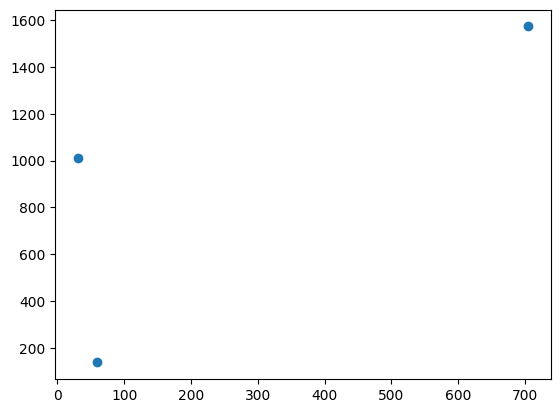

In [183]:
plt.scatter(top_3_users.followers, top_3_users.following)

In [141]:
filtered_profiles.shape

(2033081, 11)

### Using the function you previously coded, plot the time intervals with the highest average number of “likes” and the ones with the highest average number of comments on posts.

In [ ]:
# highest avg number of likes
# highes avg number of comments

# for each interval
# get all posts
# avg n likes
# avg n comments

In [186]:
time_likes_comments

,cts,numbr_likes,number_comments
0,2017-08-06 20:06:57,80.0,0.0
1,2017-06-19 09:31:16,25.0,1.0
2,2017-03-11 20:05:03,9.0,0.0
3,2016-09-13 16:27:16,4.0,0.0
4,2015-10-18 10:19:27,8.0,0.0
...,...,...,...
42710192,2017-12-13 15:38:04,74.0,0.0
42710193,2017-10-31 11:28:01,49.0,0.0
42710194,2017-01-13 20:16:37,18.0,0.0
42710195,2019-05-20 20:07:52,27.0,1.0
